# SENTIMENT ANALYSIS COVID

Tabla de contenido

1. Objetivo

<br>
Dado un conjunto de tweets, analizar si el sentimiento es positivo o negativo

2. Importo librerías y desactivbo warning

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import pandas as pd
import numpy as np


3. Carga y visualización de datos

Tenemos 2 datasets, uno para entrenamiento y otro para test

In [3]:
train_data_pandas = pd.read_csv('data/Corona_NLP_train.csv',encoding='latin-1')
test_data_pandas = pd.read_csv('data/Corona_NLP_test.csv',encoding='latin-1')

Vemos por ejemplo los datos de entrenamiento

In [4]:
train_data_pandas.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


Chequeamos test

In [5]:
test_data_pandas.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


4. Pre-procesamietno de datos

Nos interesaremos en las columnas OriginalTweet y Sentiment; a su vez veremos las distintas opciones de esta última columna

In [6]:
train_data_pandas['Sentiment'].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

Convertiremos esta columna a valores numéricos; a su vez no nos interesa ser tan específicos respecto a si un sentimiento es postivo o extremadamente positivo, más bien distinguiremos entre positivo y negativo. Los neutrales los consideraremos positivos. 

In [7]:
label_map = {'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':1,'Extremely Positive':1}
train_data_pandas['Sentiment'] = train_data_pandas['Sentiment'].map(label_map)
test_data_pandas['Sentiment'] = test_data_pandas['Sentiment'].map(label_map)

In [8]:
train_data_pandas.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0


In [9]:
print(f'Datos faltantes train:\n {train_data_pandas.isnull().sum()} \n')
print(f'Datos faltantes test:\n {test_data_pandas.isnull().sum()}')

Datos faltantes train:
 UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64 

Datos faltantes test:
 UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64


Vemos que no hay datos faltantes en las columnas que nos interesan


Vamos ahora a crear los datasets para trabajar con tensorflow

In [10]:
# Cargar el DataFrame de pandas en un objeto tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_data_pandas['OriginalTweet'].values, 
                                              train_data_pandas['Sentiment'].values))


In [11]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b'@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8'
label:  1


repito para test

In [12]:
# Cargar el DataFrame de pandas en un objeto tf.data.Dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_data_pandas['OriginalTweet'].values, 
                                                   test_data_pandas['Sentiment'].values))


buffer y batch size

In [13]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

    train_dataset: Es un objeto que representa el dataset de entrenamiento. En TensorFlow, los datasets se pueden representar como objetos de tipo tf.data.Dataset.

    shuffle(BUFFER_SIZE): Este método mezcla aleatoriamente los elementos del dataset. BUFFER_SIZE es un parámetro que determina cuántos elementos se mantendrán en el búfer de mezcla antes de tomar una muestra aleatoria. Un valor más grande del BUFFER_SIZE proporcionará una mezcla más aleatoria pero requerirá más memoria para mantener el búfer. La mezcla aleatoria es útil para asegurarse de que los datos se presenten en diferentes órdenes en cada época de entrenamiento, lo que puede ayudar a mejorar el rendimiento del modelo.

    batch(BATCH_SIZE): Este método agrupa los elementos del dataset en lotes de tamaño BATCH_SIZE. Un lote es un conjunto de ejemplos que se procesan juntos en cada paso de entrenamiento. Agrupar los datos en lotes permite aprovechar mejor la paralelización en hardware acelerado y agiliza el procesamiento. BATCH_SIZE es un parámetro que determina el tamaño de cada lote.

    prefetch(tf.data.AUTOTUNE): El método prefetch se utiliza para cargar los datos de manera anticipada, lo que permite que el procesamiento del modelo avance mientras se cargan los datos para el siguiente paso de entrenamiento. tf.data.AUTOTUNE es un valor especial que le permite a TensorFlow elegir automáticamente el número adecuado de elementos a precargar en función del entorno de ejecución y las capacidades del hardware, lo que maximiza la eficiencia del procesamiento.

En resumen, esta línea de código se encarga de mezclar aleatoriamente los datos del dataset de entrenamiento, agruparlos en lotes de tamaño especificado y cargar los lotes de manera anticipada para una ejecución más eficiente del entrenamiento del modelo.

In [14]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Veamos algunos ejemplos y sus etiquetas

In [19]:
for example, label in train_dataset.take(1):
  print(f'texts:  {example.numpy()[:3]}\n')
  print(f'labels: , {label.numpy()[:3]}')

texts:  [b'I wonder which place had the most germs right now, the hospital or the grocery store. #COVID19 #coronavirus #apocalypse2020'
 b'Sign of the times:\r\r\n\r\r\nThe only tissue-type paper left at the grocery store yesterday was \xc3\x82\xc2\x91Dude Wipes.\xc3\x82\xc2\x92 In desperation, I purchased two packs given our family\xc3\x82\xc2\x92s need to ration toilet paper over the next three weeks ?????\r\r\n\r\r\n#idontunerstand  #coronavirus https://t.co/tzTBgqXEAp'
 b'Coronavirus: Laura Ashley set to become first retail casualty of crisis https://t.co/FXAg1OXT6I']

labels: , [1 0 0]


The raw text loaded by tfds needs to be processed before it can be used in a model. The simplest way to process text for training is using the TextVectorization layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's .adapt method:

In [20]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The .adapt method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [21]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'to', 'and', 'of', 'a', 'in', 'coronavirus',
       'covid19', 'for', 'is', 'are', 'on', 'you', 'i', 'this', 'prices',
       'at', 'food'], dtype='<U19')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed output_sequence_length):

In [22]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 15,   1, 177, 344, 145,   2, 172,   1, 179,  59,   2, 523,  48,
          2,  24,  21,   9,   8,   1,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [703,   5,   2, 192,   2, 108,   1, 111, 380,  18,   2,  24,  21,
        540,  73,   1,   1,   7,   1,  15,   1, 254,   1, 618,  39,   1,
         63,   3,   1, 105, 111, 113,   2, 246, 663, 217,   1,   8,   1,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  8,   1,   1, 493,   3, 660, 187, 107,   1,   5,  97,   1,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

    The default value for preprocessing.TextVectorization's standardize argument is "lower_and_strip_punctuation".
    The limited vocabulary size and lack of character-based fallback results in some unknown tokens.


In [23]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I wonder which place had the most germs right now, the hospital or the grocery store. #COVID19 #coronavirus #apocalypse2020'
Round-trip:  i [UNK] which place had the most [UNK] right now the hospital or the grocery store covid19 coronavirus [UNK]                                   

Original:  b'Sign of the times:\r\r\n\r\r\nThe only tissue-type paper left at the grocery store yesterday was \xc3\x82\xc2\x91Dude Wipes.\xc3\x82\xc2\x92 In desperation, I purchased two packs given our family\xc3\x82\xc2\x92s need to ration toilet paper over the next three weeks ?????\r\r\n\r\r\n#idontunerstand  #coronavirus https://t.co/tzTBgqXEAp'
Round-trip:  sign of the times the only [UNK] paper left at the grocery store yesterday was [UNK] [UNK] in [UNK] i [UNK] two [UNK] given our [UNK] need to [UNK] toilet paper over the next three weeks [UNK] coronavirus [UNK]               

Original:  b'Coronavirus: Laura Ashley set to become first retail casualty of crisis https://t.co/FXAg1OXT6I'
Ro

# 5. MODELO

Definimos el modelo, la arquitectura se muestra en la figura siguiente:


<img src="images/Model.png"/>



In [24]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

The embedding layer uses masking to handle the varying sequence-lengths. All the layers after the Embedding support masking:

In [25]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Sentencias de prueba

In [28]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie but bla assa i dont know what to say, whaaaat.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])


1/1 [==============================] - 2s 2s/step
[0.21192755]


Compilamos; como es un problema con 2 clases usamos BinaryCrossentrpy

In [26]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Entrenamos durante 8 epochs

In [36]:
history = model.fit(
                    train_dataset, 
                    epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/5
644/644 [==============================] - 22s 35ms/step - loss: 0.4025 - accuracy: 0.8151 - val_loss: 0.4785 - val_accuracy: 0.7750
Epoch 2/5
644/644 [==============================] - 22s 35ms/step - loss: 0.3995 - accuracy: 0.8165 - val_loss: 0.4840 - val_accuracy: 0.7536
Epoch 3/5
644/644 [==============================] - 22s 34ms/step - loss: 0.3963 - accuracy: 0.8164 - val_loss: 0.4758 - val_accuracy: 0.7714
Epoch 4/5
644/644 [==============================] - 22s 34ms/step - loss: 0.3935 - accuracy: 0.8175 - val_loss: 0.4774 - val_accuracy: 0.7599
Epoch 5/5
644/644 [==============================] - 22s 35ms/step - loss: 0.3910 - accuracy: 0.8171 - val_loss: 0.4798 - val_accuracy: 0.7682


Evaluamos

In [37]:
test_loss, test_acc = model.evaluate(test_dataset)


60/60 [==============================] - 1s 12ms/step - loss: 0.4756 - accuracy: 0.7720


(0.0, 0.48862520009279253)

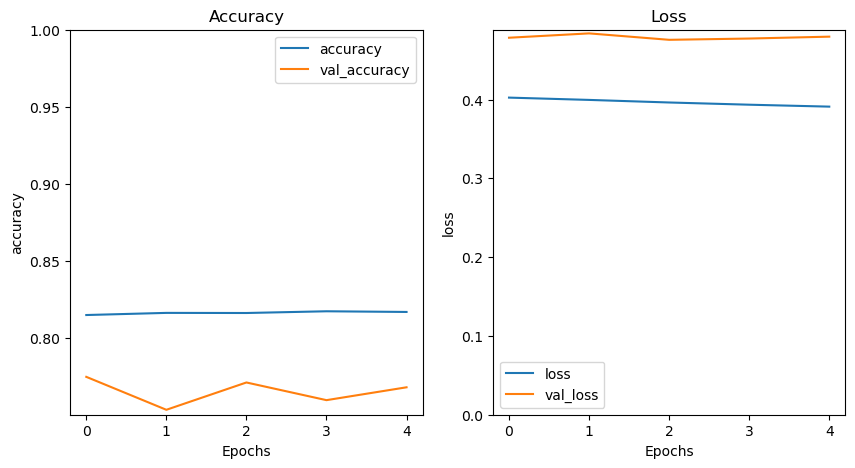

In [47]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.title('Accuracy')
plt.ylim(None, 1)

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.title('Loss')
plt.ylim(0, None)


# 6. AJUSTE DE HIPERPARÁMETROS

Cambiaremos la arqutectura del modelo (usaremos 2 LSTMs bidireccionales)
